In [1]:
!pip install pytrends
!pip install bambi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 495.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 2.7 MB/s eta 0:00:00


In [52]:
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import plotly.express as px

## Fetch the Trends Data

In [53]:

# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Define keyword
keyword = 'meta'

# Build payload
pytrends.build_payload(kw_list=[keyword])

# Get interest over time
df = pytrends.interest_over_time()

# Print the fetched data
print(df)

            meta  isPartial
date                       
2018-12-30    19      False
2019-01-06    19      False
2019-01-13    20      False
2019-01-20    19      False
2019-01-27    20      False
...          ...        ...
2023-11-26    71      False
2023-12-03    77      False
2023-12-10    75      False
2023-12-17    83      False
2023-12-24    77       True

[261 rows x 2 columns]


## Plot the Data

In [89]:
fig = px.line(df, y='meta', labels={'meta': 'Search Interest'}, title='Search Interest for the Word "meta"')
fig.update_traces(line=dict(width=3))  # Increase line width for emphasis
fig.update_layout(title_font=dict(size=20), xaxis_title='Time', yaxis_title='Search Interest',
                  font=dict(family="Arial", size=12), height=500, width=800, yaxis=dict(range=[0, 100]))
fig.show()


## Plot the Target Distribution

(array([145.,   3.,   8.,  32.,  32.,  21.,   9.,   8.,   1.,   2.]),
 array([ 17. ,  25.3,  33.6,  41.9,  50.2,  58.5,  66.8,  75.1,  83.4,
         91.7, 100. ]),
 <BarContainer object of 10 artists>)

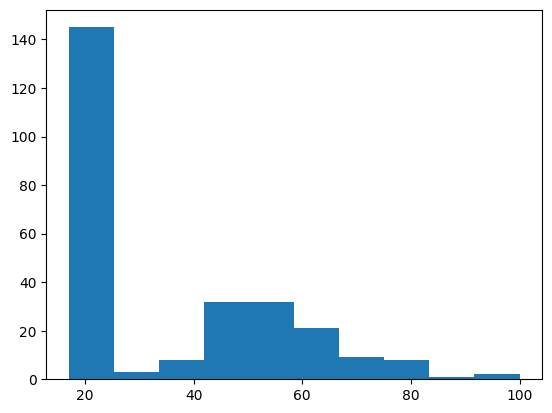

In [55]:
plt.hist(df['meta'])

## Create the Intervention Variable

In [56]:
df['dt_month'] = [str(x.year) + '_' + str(x.month) for x in df.index]

In [57]:
df['name_change'] = np.isin(df['dt_month'],['2021_10','2021_11']).astype('int')
df['name_change_cum'] = np.cumsum(np.abs(np.diff(df['name_change'], prepend=0)))

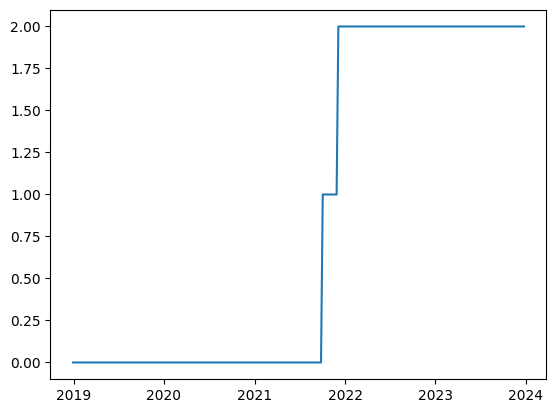

In [58]:
plt.plot(df['name_change_cum'])

In [59]:
df['intervention'] = 0
df.loc[df['name_change_cum'] == df['name_change_cum'].max(), 'intervention'] = 1


In [60]:
df.loc[~np.isin(df['name_change_cum'],np.array([0,df['name_change_cum'].max()])), 'intervention'] = pd.NA

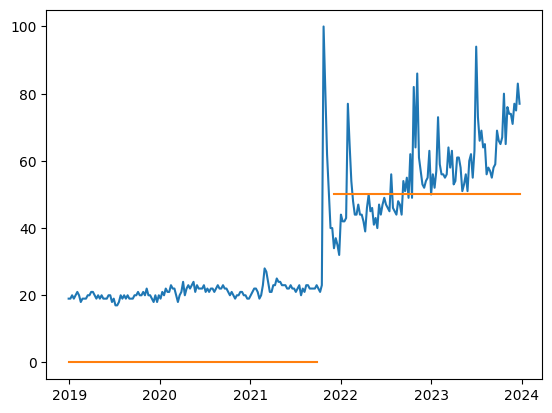

In [61]:
plt.plot(df['meta'])
plt.plot(df['intervention']*50)
#plt.plot(df['name_change_cum'])

In [62]:
df['t'] = np.arange(df.shape[0])

In [63]:
df['t_pre'] = 1
df.loc[df['intervention'] == 1, 't_pre'] = 0

df['t_post'] = 1
df.loc[df['intervention'] == 0, 't_post'] = 0

df['t_pre']=df['t_pre']*df['t']
df['t_post']=df['t_post']*df['t']

## Finalize the dataset

In [64]:
df = df.loc[:,['meta','t_pre','t_post','t','intervention']]

In [65]:
df

,meta,t_pre,t_post,t,intervention
date,,,,,
2018-12-30,19,0,0,0,0.0
2019-01-06,19,1,0,1,0.0
2019-01-13,20,2,0,2,0.0
2019-01-20,19,3,0,3,0.0
2019-01-27,20,4,0,4,0.0
...,...,...,...,...,...
2023-11-26,71,0,256,256,1.0
2023-12-03,77,0,257,257,1.0
2023-12-10,75,0,258,258,1.0


## Regression Model with StatsModels

In [71]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import bambi as bmb

# Assuming df is your DataFrame with columns 'meta', 'intervention', and 'time'

# Define the formula for the linear mixed-effects model
formula = 'meta ~ t_pre + t_post +intervention + 1'

# Fit the linear mixed-effects model
model = smf.ols(formula, df.dropna())
result = model.fit()

# Print the summary of the model
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   meta   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     894.9
Date:                Thu, 28 Dec 2023   Prob (F-statistic):          1.13e-132
Time:                        16:05:42   Log-Likelihood:                -790.34
No. Observations:                 252   AIC:                             1589.
Df Residuals:                     248   BIC:                             1603.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       19.0754      0.931     20.492   

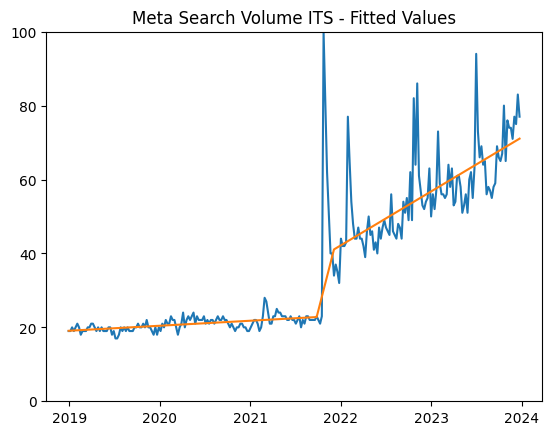

In [72]:
y_p = result.fittedvalues
plt.plot(df['meta'])
plt.plot(y_p)
plt.title("Meta Search Volume ITS - Fitted Values")
plt.ylim(0,100)
plt.show()


Text(0.5, 1.0, 'Error Distribution')

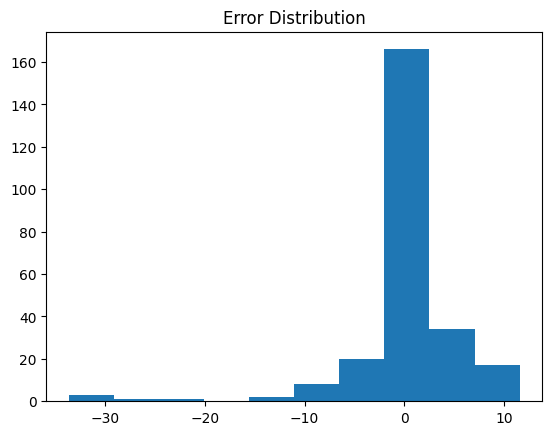

In [20]:
plt.hist(np.array(result.fittedvalues) - np.array(df.dropna()['meta']))
plt.title('Error Distribution')

Text(0.5, 1.0, 'Residuals over Time')

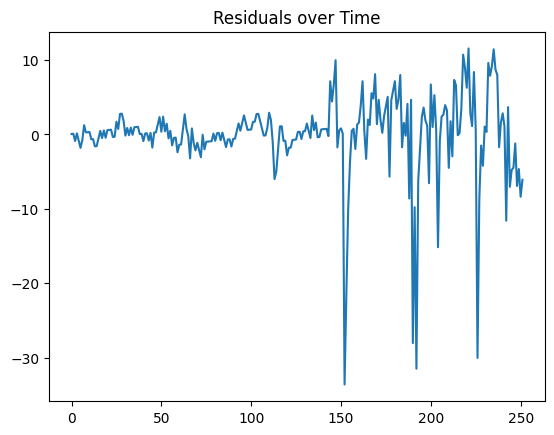

In [21]:
plt.plot(np.array(result.fittedvalues) - np.array(df.dropna()['meta']))
plt.title('Residuals over Time')

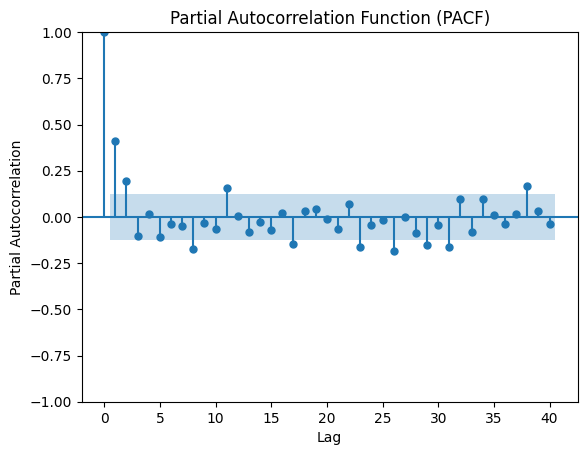

In [22]:
from statsmodels.tsa.stattools import pacf

# Plot PACF
sm.graphics.tsa.plot_pacf(np.array(result.fittedvalues) - np.array(df.dropna()['meta']), lags=40)  # Adjust the number of lags as needed
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


## Bayesian Regression Model

In [23]:
# Fit the Bayesian mixed-effects model using Bambi
model = bmb.Model('meta ~ t_pre + t_post + 1 + intervention', dropna=True, data=df)
result = model.fit(draws=5000, chains=2)

# Print the summary of the model
print(result)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,19.074,0.925,17.280,20.758,0.010,0.007,8044.0,6930.0,1.0
t_pre,0.026,0.011,0.005,0.047,0.000,0.000,7864.0,6125.0,1.0
t_post,0.278,0.017,0.245,0.310,0.000,0.000,4480.0,5277.0,1.0
intervention,-20.378,3.748,-27.151,-13.047,0.056,0.040,4472.0,5469.0,1.0
meta_sigma,5.605,0.252,5.128,6.067,0.003,0.002,8468.0,6683.0,1.0


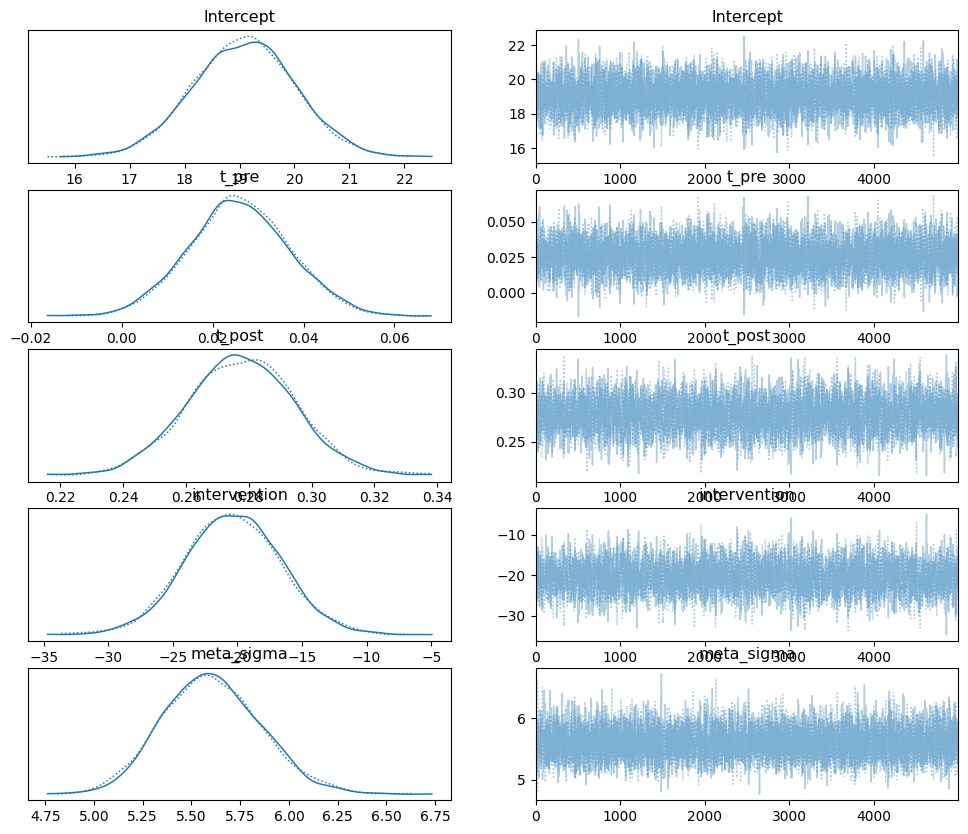

In [24]:
import arviz as az
az.plot_trace(result)
az.summary(result)

## Counterfactual

In [28]:
y_counterfactual = 19.074 + np.array(0.026*df['t_post'])
df['y_counterfactual'] = y_counterfactual

y_counterfactual = 20.758 + np.array(0.047*df['t_post'])
df['y_counterfactual_p97'] = y_counterfactual

y_counterfactual = 17.28 + np.array(0.005*df['t_post'])
df['y_counterfactual_p3'] = y_counterfactual

In [32]:
df.loc[df['intervention'] != 1, 'y_counterfactual'] = pd.NA
df.loc[df['intervention'] != 1, 'y_counterfactual_p3'] = pd.NA
df.loc[df['intervention'] != 1, 'y_counterfactual_p97'] = pd.NA

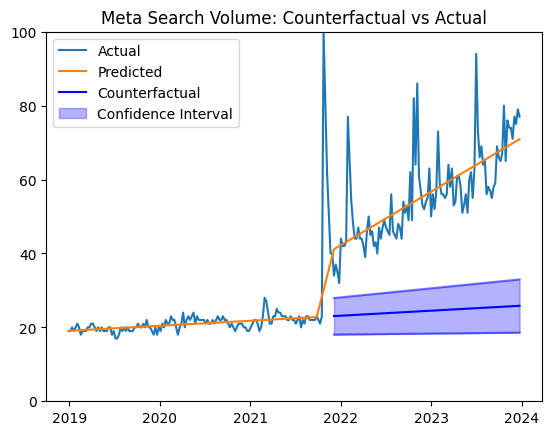

In [35]:
import matplotlib.pyplot as plt

# Assuming df['meta'], y_p, df['y_counterfactual'], df['y_counterfactual_p97'], and df['y_counterfactual_p3'] are available

# Plot the lines
plt.plot(df['meta'], label='Actual')
plt.plot(y_p, label='Predicted')
plt.plot(df['y_counterfactual'], label='Counterfactual', color='blue')
plt.plot(df['y_counterfactual_p97'], color='blue', alpha=0.5)
plt.plot(df['y_counterfactual_p3'], color='blue', alpha=0.5)

# Shade the area between p3 and p97 percentiles
plt.fill_between(df.index, df['y_counterfactual_p3'], df['y_counterfactual_p97'], color='blue', alpha=0.3, label='Confidence Interval')

# Set plot attributes
plt.title("Meta Search Volume: Counterfactual vs Actual")
plt.ylim(0, 100)
plt.legend()
plt.show()


In [37]:
df_post = df[df['intervention'] == 1]

(0.0, 100.0)

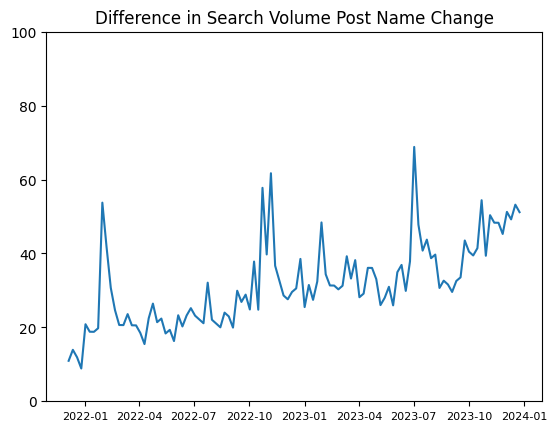

In [38]:
plt.plot((df_post['meta'] - df_post['y_counterfactual']))
plt.title('Difference in Search Volume Post Name Change')
plt.xticks(fontsize=8)
plt.ylim(0,100)

In [41]:
df_post['meta'].sum()

6051

In [39]:
df_post['y_counterfactual'].sum()

2639.844

In [42]:
df_post['meta'].sum() - df_post['y_counterfactual'].sum()

3411.156